## Traininig the Inclusive classifier with tf.Keras using data in TFRecord format

**tf.keras Inclusive classifier** This notebooks trains a neural network for the particle classifier using the Inclusive Classifier, using as input the list of recunstructed particles with the low level features + the high level features. Data is prepared from Parquet using Apache Spark, and written into TFRecord format. Data in TFRecord format is read from TensorFlow using tf.data and tf.io in tf.keras.

To run this notebook we used the following configuration:
* *Software stack*: TensorFlow 2.0.1
* *Platform*: CentOS 7, Python 3.6

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Masking, Dense, Activation, GRU, Dropout, concatenate

tf.version.VERSION
# only needed for TensorFlow 1.x
# tf.enable_eager_execution()

'2.0.1'

# Configure distributed training using tf.distribute
This notebook shows an example of distributed training with tf.keras using 4 concurrent executions on a single machine.
The test machine has 24 physical cores it has been notes that a serial execution of the training would leave spare capacity. With distributed training we can "use all the CPU on the box". 
- TensorFlow MultiWorkerMirroredStrategy is used to distribute the training.
- Configuration of the workers is done using the OS enviroment variable **TF_CONFIG**.
- **nodes_endpoints** configures the list of machines and ports that will be used. In this example, we use 3 workers on the same machines, you can use this to distribute over multiple machines too
- **worker_number** will be unique for each worker, numbering starts from 0
- Worker number 0 will be the master. 
- You need to run the 4 notebooks for the 4 configured workers at the same time (training will only start when all 4 workers are active) 

In [3]:
# Each worker will have a unique worker_number, numbering starts from 0
worker_number=0

nodes_endpoints = ["localhost:12345", "localhost:12346", "localhost:12347", "localhost:12348"]
number_workers = len(nodes_endpoints)

import os
import json
os.environ['TF_CONFIG'] = json.dumps({
    'cluster': {
        'worker': nodes_endpoints
    },
    'task': {'type': 'worker', 'index': worker_number}
})


In [4]:
strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()

## Create the Keras model for the inclusive classifier hooking with tf.distribute

In [5]:
# This implements the distributed stratedy for model
with strategy.scope():
    ## GRU branch
    gru_input = Input(shape=(801,19), name='gru_input')
    a = gru_input
    a = Masking(mask_value=0.)(a)
    a = GRU(units=50,activation='tanh')(a)
    gruBranch = Dropout(0.2)(a)
    
    hlf_input = Input(shape=(14), name='hlf_input')
    b = hlf_input
    hlfBranch = Dropout(0.2)(b)

    c = concatenate([gruBranch, hlfBranch])
    c = Dense(25, activation='relu')(c)
    output = Dense(3, activation='softmax')(c)
    
    model = Model(inputs=[gru_input, hlf_input], outputs=output)
    
    ## Compile model
    optimizer = 'Adam'
    loss = 'categorical_crossentropy'
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"] )

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_input (InputLayer)          [(None, 801, 19)]    0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, 801, 19)      0           gru_input[0][0]                  
__________________________________________________________________________________________________
gru (GRU)                       (None, 50)           10650       masking[0][0]                    
__________________________________________________________________________________________________
hlf_input (InputLayer)          [(None, 14)]         0                                            
______________________________________________________________________________________________

## Load test and training data in TFRecord format, using tf.data and tf.io

In [7]:
PATH = "/local3/lucatests/Data/"

# test dataset 
files_test_dataset = tf.data.Dataset.list_files(PATH + "testUndersampled.tfrecord/part-r*", shuffle=False)

# training dataset 
files_train_dataset = tf.data.Dataset.list_files(PATH + "trainUndersampled.tfrecord/part-r*", seed=4242)

In [8]:
# tunable
num_parallel_reads=16

test_dataset = files_test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).interleave(
    tf.data.TFRecordDataset, 
    cycle_length=num_parallel_reads,
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_dataset = files_train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).interleave(
    tf.data.TFRecordDataset, cycle_length=num_parallel_reads,
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [9]:
# Function to decode TF records into the required features and labels
def decode(serialized_example):
    deser_features = tf.io.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
          'HLF_input': tf.io.FixedLenFeature((14), tf.float32),
          'GRU_input': tf.io.FixedLenFeature((801,19), tf.float32),
          'encoded_label': tf.io.FixedLenFeature((3), tf.float32),
          })
    return((deser_features['GRU_input'], deser_features['HLF_input']), deser_features['encoded_label'])

In [10]:
# use for debugging
# for record in test_dataset.take(1):
#     print(record)

In [11]:
parsed_test_dataset=test_dataset.map(decode, num_parallel_calls=tf.data.experimental.AUTOTUNE)
parsed_train_dataset=train_dataset.map(decode, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()

In [12]:
# use for debugging
# Show and example of the parsed data
# for record in parsed_test_dataset.take(1):
#    print(record)

In [13]:
# tunable
batch_size = 128 * number_workers

train=parsed_train_dataset.batch(batch_size)
train=train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
train=train.repeat()
train

<DatasetV1Adapter shapes: (((None, 801, 19), (None, 14)), (None, 3)), types: ((tf.float32, tf.float32), tf.float32)>

In [14]:
num_train_samples=3426083   # there are 3426083 samples in the training dataset

steps_per_epoch=num_train_samples//batch_size
steps_per_epoch

6691

In [15]:
# tunable
test_batch_size = 1024 

test=parsed_test_dataset.batch(test_batch_size)
test=test.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test=test.repeat()

In [16]:
num_test_samples=856090 # there are 856090 samples in the test dataset

validation_steps=num_test_samples//test_batch_size  
validation_steps

836

## Train the tf.keras model

In [17]:
# train the Keras model

# tunable
num_epochs = 6

# callbacks = [ tf.keras.callbacks.TensorBoard(log_dir='./logs') ]
callbacks = []
    
%time history = model.fit(train, steps_per_epoch=steps_per_epoch, \
                          epochs=num_epochs, callbacks=callbacks, verbose=1)
                          # validation_data=test, validation_steps=validation_steps, \


W0311 13:38:06.646841 139938125788992 distribute_coordinator.py:825] `eval_fn` is not passed in. The `worker_fn` will be used if an "evaluator" task exists in the cluster.
W0311 13:38:06.647871 139938125788992 distribute_coordinator.py:829] `eval_strategy` is not passed in. No distribution strategy will be used for evaluation.
W0311 13:38:06.649680 139938125788992 distributed_training_utils.py:1163] ModelCheckpoint callback is not provided. Workers will need to restart training if any fails.


Train for 6691 steps
Epoch 1/6
6691/6691 [==============================] - 4681s 700ms/step - loss: 0.2853 - accuracy: 0.8928
Epoch 2/6
6691/6691 [==============================] - 4657s 696ms/step - loss: 0.1951 - accuracy: 0.9284
Epoch 3/6
6691/6691 [==============================] - 4641s 694ms/step - loss: 0.1697 - accuracy: 0.9382
Epoch 4/6
6691/6691 [==============================] - 4641s 694ms/step - loss: 0.1557 - accuracy: 0.9435
Epoch 5/6
6691/6691 [==============================] - 4632s 692ms/step - loss: 0.1481 - accuracy: 0.9465
Epoch 6/6
6691/6691 [==============================] - 4622s 691ms/step - loss: 0.1421 - accuracy: 0.9487
CPU times: user 1d 1h 59min 4s, sys: 5h 57min 22s, total: 1d 7h 56min 26s
Wall time: 7h 44min 36s


In [18]:
PATH="/local1/lucatests/SparkDLTrigger/Training_TFKeras_Distributed/model/"
model.save(PATH + "mymodel" + str(worker_number) + ".h5", save_format='h5')

## Training history performance metrics

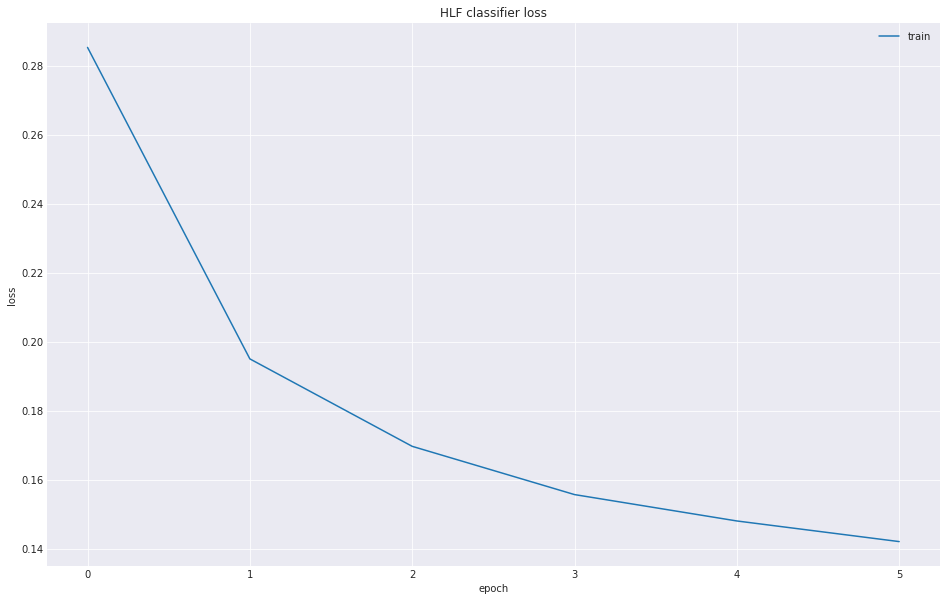

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = [16, 10]
plt.style.use('seaborn-darkgrid')
# Graph with loss vs. epoch

plt.figure()
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title("HLF classifier loss")
plt.show()

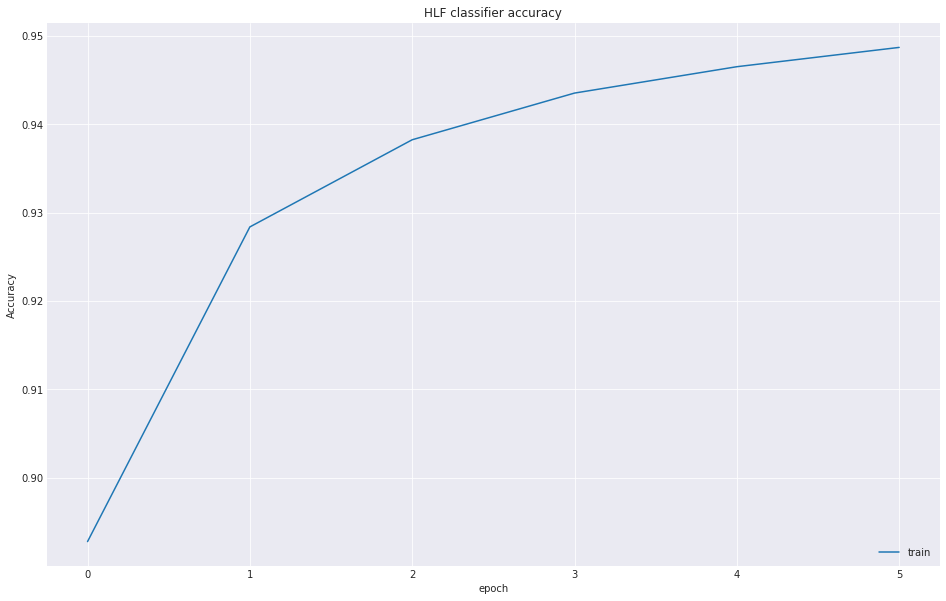

In [22]:
# Graph with accuracy vs. epoch
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 10]
plt.figure()
plt.plot(history.history['accuracy'], label='train')
#plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title("HLF classifier accuracy")
plt.show()

## Model performance metrics
Load the model and plot the ROC and AUC and te confusion matrix using the noteboook  
**4.3a-Model_evaluate_ROC_and_CM.ipynb**